### **Leaftracker Image Classification Model**
Image Classification Model that determines whether a plant is either toxic or nontoxic. The toxic plants can vary between: western poison oak, eastern poison oak, eastern poison ivy, western poison ivy, and poison sumac. The non-toxic plants can vary between: Virginia creeper, boxelder, Jack-in-the-pulpit, bear oak, and fragrant sumac.

Credit to [Tensorflow's documentation](https://www.tensorflow.org/tutorials/images/classification) for how to create an image segmentation model using their library. Code from the documentation was both used and incorporated for learning about machine learning while also completing this personal project.

In [1]:
# run on python 3.9.6
# import the following libraries to use for the model and visualizing its accuracy and loss
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **Download + Explore the Dataset**

In [2]:
import pathlib
data_dir = "tpc-imgs"
data_dir = pathlib.Path(data_dir)

### **Load data using a Keras utility**

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9952 files belonging to 10 classes.
Using 7962 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9952 files belonging to 10 classes.
Using 1990 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['bear_oak', 'boxelder', 'eastern_poison_ivy', 'eastern_poison_oak', 'fragrant_sumac', 'jack_in_the_pulpit', 'poison_sumac', 'virginia_creeper', 'western_poison_ivy', 'western_poison_oak']


### **Visualize the Data**

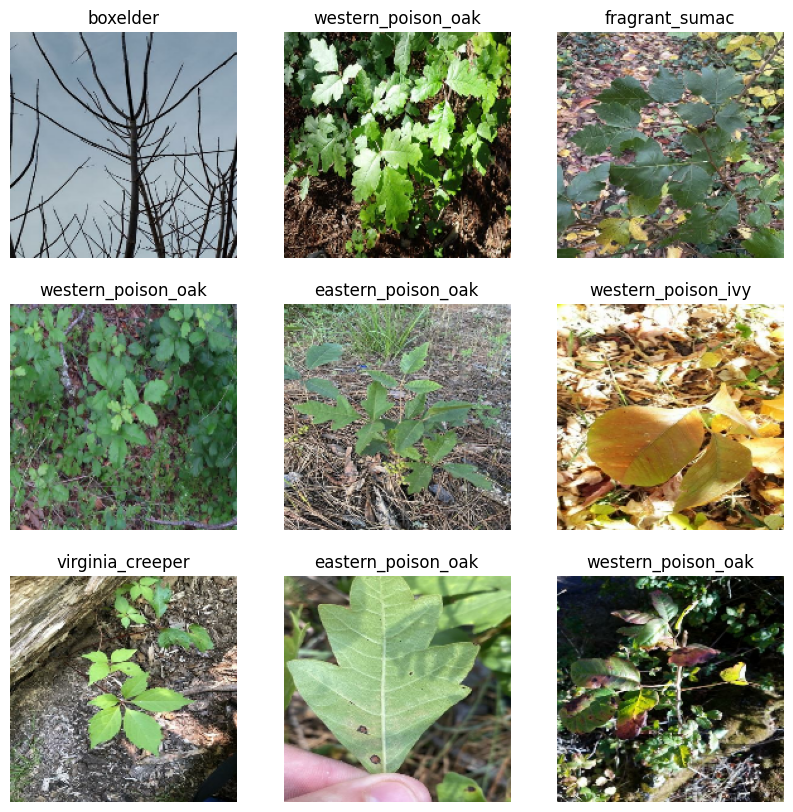

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### **Configure the dataset for performance**

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Standardize the Data**

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### **TensorFlow Keras Model**

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times.

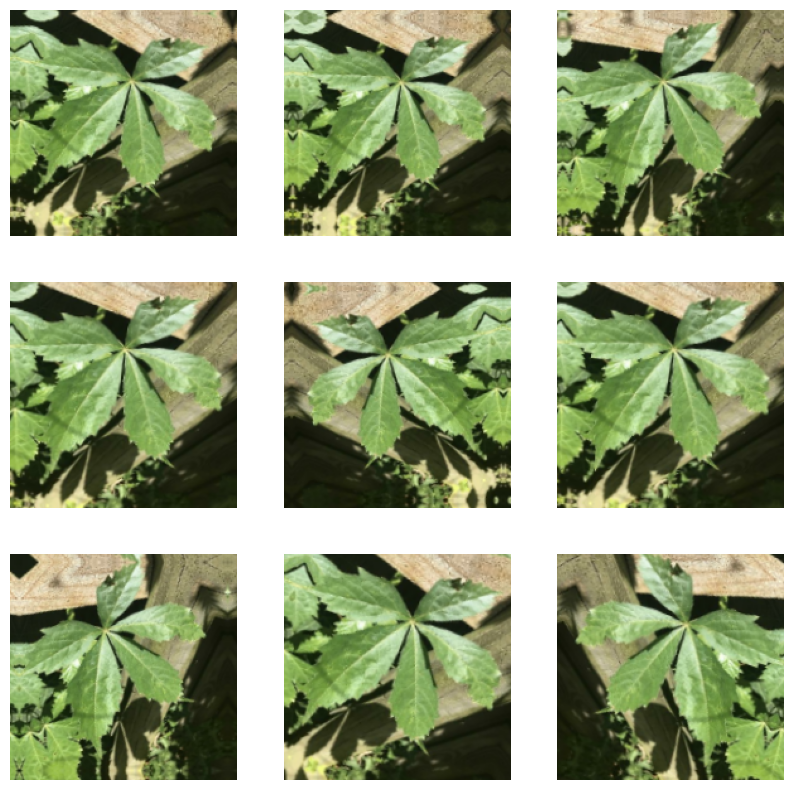

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**<br>

In [28]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

**Compile and Train the Model**

In [29]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [16]:
# filename='callbacks_log.csv'
# history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [32]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/20
249/249 [==============================] - 277s 1s/step - loss: 2.3007 - accuracy: 0.1172 - val_loss: 2.2883 - val_accuracy: 0.1281
Epoch 2/20
249/249 [==============================] - 275s 1s/step - loss: 2.2632 - accuracy: 0.1523 - val_loss: 2.2430 - val_accuracy: 0.1678
Epoch 3/20
249/249 [==============================] - 276s 1s/step - loss: 2.2321 - accuracy: 0.1701 - val_loss: 2.1807 - val_accuracy: 0.1854
Epoch 4/20
249/249 [==============================] - 241s 966ms/step - loss: 2.1915 - accuracy: 0.1890 - val_loss: 2.1683 - val_accuracy: 0.1920
Epoch 5/20
249/249 [==============================] - 242s 971ms/step - loss: 2.1432 - accuracy: 0.2139 - val_loss: 2.1681 - val_accuracy: 0.2090
Epoch 6/20
249/249 [==============================] - 250s 1s/step - loss: 2.1184 - accuracy: 0.2249 - val_loss: 2.1072 - val_accuracy: 0.2126
Epoch 7/20
249/249 [==============================] - 299s 1s/step - loss: 2.0935 - accuracy: 0.2367 - val_loss: 2.0965 - val_accuracy: 

In [38]:
import csv
d = history.history

n = len(d["loss"])
with open("callbacks_log.csv", "w") as f:
    csv_writer = csv.writer(f, lineterminator="\n")
    header = ["epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
    csv_writer.writerow(header)

    for i in range(n):
        loss = d["loss"][i]
        accuracy = d["accuracy"][i]
        val_loss = d["val_loss"][i]
        val_accuracy = d["val_accuracy"][i]
        csv_writer.writerow([i, loss, accuracy, val_loss, val_accuracy])

**Visualize Training Results**

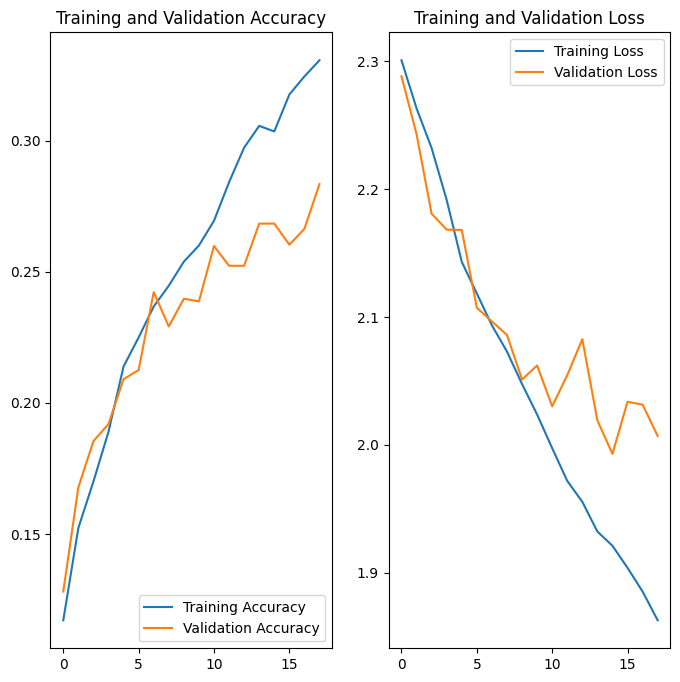

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Predict on New Data**

In [ ]:
test_path = "poison_sumac.jpg"

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 651ms/step
This image most likely belongs to poison_sumac with a 44.60 percent confidence.


### **Save the Model**

In [42]:
!mkdir saved_model
model.save('saved_model/')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


### **TensorFlow Lite Model**

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('saved_model/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\lukel\AppData\Local\Temp\tmpcml733zs\assets


INFO:tensorflow:Assets written to: C:\Users\lukel\AppData\Local\Temp\tmpcml733zs\assets


In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

ValueError: Could not open 'model.tflite'.

In [ ]:
interpreter.get_signature_list()

In [ ]:
classify_lite = interpreter.get_signature_runner("serving_default")
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))